#Homework 1: Fama-Bliss

####Question 1
Obtain the Fama-Bliss bond price data. Use the data starting in 1964 (observation 140), as Fama and Bliss do, but extending until now. We're going to replicate and extend the Fama-Bliss regressions shown in lecture. You will not get exactly the same numbers as were presented in lecture, because I have updated the data. The numbers shown in lecture will be close enough to be a guide, but not close enough to answer this quiz correctly! The data are price per \$100 face value, our definitions have been per $1 face value, so adjust appropriately. 

Start by forming log prices, log yields, and log forward rates. Report the average log yield on maturities 1,2,3,4,5, in percent (3, not 0.03), separated by a space, with two decimals. Besides checking that you're on the right track, this answers the question, does the yield curve on average slope up or slope down? 

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as sm

In [40]:
# Get data from file
bond_prices = pd.read_csv('https://d396qusza40orc.cloudfront.net/assetpricing%2Fdata%2FFama_\
                          Bliss_price.txt', sep ='\s+', skiprows = 2, 
                          names = ['price{:}'.format(i) for i in range(1,6)], 
                          index_col = 0, parse_dates = True) 

# Start from the right date and scale prices down by 100
fb_data = bond_prices.ix['1964-01-01':] / 100.
# Calculate log prices and log yields
fb_data = fb_data.join(-fb_data.apply(np.log) / np.arange(1,6), rsuffix ='_log_yield')

# Report average log yield by maturities
print('{:.4f} {:.4f} {:.4f} {:.4f} {:.4f}'.format(*fb_data[[col for col in fb_data.columns 
                                        if col.endswith('_log_yield') ]].mean(axis = 0) * 100))

5.6314 5.8416 6.0224 6.1775 6.2854


####Question 2

Next, form annual log returns and excess log returns (excess over the one year rate),

$$r^{(n)}_{t+1}=p^{(n−1)}_{t+1}−p^{(n)}_t$$

$$rx^{(n)}_{t+1}=r^{(n)}_{t+1}−y^{(1)}_t$$

The most common source of trouble is not implementing the definitions of forward rate and return correctly. The first log return on a two year bond is the Jan 1965 log price of a one year bond minus the Jan 1964 price of a two year bond. The second log return on a two year bond is the Feb 1965 log price of a one year bond minus the Feb 1964 log price of a two year bond.

Calculate the mean and standard deviation of these annual log excess returns. Report the Sharpe ratio (of log returns),

$$E(rx^{(n)}_{t+1})/\sigma(rx^{(n)}_{t+1})$$


In [53]:
# Generate returns by applying the formula above
rets = pd.DataFrame(fb_data.ix[12:, :4].apply(np.log).values - \
                    fb_data.ix[:-12, 1:5].apply(np.log).values,
                    index = fb_data.index[12:], 
                    columns = ['return_{:}'.format(i) for i in range(1,5)])

# Compute excess returns by subtracting 1 year returns 
x_rets = rets.subtract(-fb_data.price1[:-12].apply(np.log).values, axis = 0)

# Report Sharpe Ratios
print('{:.4f} {:.4f} {:.4f} {:.4f}'.format(*x_rets.mean(axis = 0) / x_rets.std(axis = 0)))

0.2803 0.2760 0.2695 0.2411


####Question 3
Now, we're ready to have fun! Run the Fama-Bliss regression of excess returns on forward-spot spreads.

$$rx^{(n)}_{t+1}=a_n+b_n(f^{(n)}_t−y^{(1)}_t)+\epsilon^{(n)}_{t+1}$$

This regression uses overlapping monthly observations of annual returns. So, for example, your first data point is the return from January 1964 to January 1965 on the January 1964 spread. Your second data point is the return from February 1964 to Feburary 1965 on the February 1964 spread. And so on.

Yes, this is ok -- regressions need the error term to be uncorrelated with the right hand variable, and overlapping data doesn't affect that. Overlapping data does mean the errors are correlated over time, so your standard errors are garbage. In a deeper look at this problem I would have you compute standard errors from non-overlapping data, and apply the GMM/Hansen Hodrick and Newey-West corrections for serially correlated errors. Not today.

Today, compute $a_n$, $b_n$, and $R^2$ and verify that you're getting numbers close to those presented in lecture. Report the $b_n$ coefficients. You are reporting four numbers, for maturity n=2,3,4,5, separated by a space to two decimal places. Item for review -- what did the simple expectations hypothesis say these $b$ coefficients should be?


In [54]:
# Calculate forward rates and spreads
fwd_rates = fb_data.ix[:, :4].apply(np.log) - fb_data.ix[:, 1:5].apply(np.log).values
fwd_rates.columns = ['fwd_{:}'.format(i) for i in range(1,5)]
fwd_spread = fwd_rates.subtract(-fb_data.price1.apply(np.log).values, axis = 0)

# Run Regressions
fb_reg_xs_ret = [sm.ols('rx ~ fwd_spread', data = {'rx' : x_rets.ix[:, i].values, 
                 'fwd_spread' : fwd_spread.ix[:-12, i].values}).fit() for i in range(4)]

# Get b values
print('{:.4f} {:.4f} {:.4f} {:.4f}'.format(*[fb_reg_xs_ret[i].params.fwd_spread for 
                                             i in range(4)]))

[fb_reg_xs_ret[i].summary() for i in range(4)]

0.8355 1.1464 1.3939 1.1403


[<class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:                     rx   R-squared:                       0.117
 Model:                            OLS   Adj. R-squared:                  0.115
 Method:                 Least Squares   F-statistic:                     76.57
 Date:                Tue, 05 May 2015   Prob (F-statistic):           2.31e-17
 Time:                        15:11:48   Log-Likelihood:                 1552.0
 No. Observations:                 582   AIC:                            -3100.
 Df Residuals:                     580   BIC:                            -3091.
 Df Model:                           1                                         
 Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
 ---------------------------------------------------------------------

####Question 4

Next, the right hand panel. Run the regression of n-year changes in the one-year rate on the forward-spot spread.

$$y^{(1)}_{t+n−1}−y^{(1)}_t=a_n+b_n(f^{(n)}_t−y^{(1)}_t)+\epsilon_{t+n}$$

Calculate $a_n$, $b_n$,and $R^2$. Report your four $b_n$ values, separated by a space, to two decimal places. Each regression should contain the maximum number of data points for that maturity, so your sample will change across regressions. Item for review: What did the simple expectations hypothesis say these numbers should be?


In [55]:
# Generate returns by applying the formula above
fb_reg_yield_change = [sm.ols('rate_change ~ fwd_spread', data = {'rate_change' :
                       fb_data.ix[:-12*i, 0].apply(np.log).values - \
                       fb_data.ix[12*i:, 0].apply(np.log).values, 'fwd_spread' : 
                       fwd_spread.ix[:-12*i, i-1].values}).fit() for i in range (1,5)]

# Get b values
print('{:.4f} {:.4f} {:.4f} {:.4f}'.format(*[fb_reg_yield_change[i].params.fwd_spread for 
                                             i in range(4)]))

[fb_reg_yield_change[i].summary() for i in range(4)]

0.1645 0.5035 0.7674 0.8950


[<class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:            rate_change   R-squared:                       0.005
 Model:                            OLS   Adj. R-squared:                  0.003
 Method:                 Least Squares   F-statistic:                     2.969
 Date:                Tue, 05 May 2015   Prob (F-statistic):             0.0854
 Time:                        15:11:54   Log-Likelihood:                 1552.0
 No. Observations:                 582   AIC:                            -3100.
 Df Residuals:                     580   BIC:                            -3091.
 Df Model:                           1                                         
 Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
 ---------------------------------------------------------------------

####Question 5
The regression coefficients $b_2$ add up to one. As I explained with a little picture in lecture, they add up by construction. As you raise the dot in the middle, representing the price of one-year bonds one year in the future, you raise the return of two year bonds at time 0, and you lower the one year rate at time 1. Those two components add up ex post, so they also add up ex ante. In equations, we start by breaking the return from t to t+n

$0-p^{(2)}_t = [0-p^{(1)}_{t+1}] + [p^{(1)}_{t+1}-p^{(2)}_t ] \ \leftarrow$ this expresses how the price rise happens in period 1 and period 2

$-p^{(2)}_t = y^{(1)}_{t+1} + r^{(2)}_{t+1}$

$f^{(2)}_t=p^{(1)}_t-p^{(2)}_t = -y^{(1)}_t + r^{(2)}_{t+1}+y^{(1)}_{t+1}$

$f^{(2)}_t-y^{(1)}_t = [r^{(2)}_{t+1}-y^{(1)}_t]+[y^{(1)}_{t+1}-y^{(1)}_t]$

$f^{(2)}_t-y^{(1)}_t = rx^{(2)}+[y^{(1)}_{t+1}-y^{(1)}_t]$

Mechanically, the forward-spot spread, which is on the right hand side of the regressions, is always equal, ex-post, to the sum of excess returns on two period bonds in the first period, and the change in one year yield. Now, regress both sides of this equation on $f^{(2)}_t−y^{(1)}_t$. The left hand side is one. The right hand side is the sum of the return forecast and yield change forecast coefficients.

So far, so good. But the other rows do not add up to one. Why not? Aha! They aren't exactly matched in this way. To each one-year return forecast that comes out to about one there is a yield change forecast that comes out to about zero, and to each yield change forecast you did there is a corresponding return forecast. Now, what are they?

I suggest that you approach this question by making a little drawing as I did in class, with price on the vertical axis and time on the horizontal axis. Draw in the paths that 2,3,4,5 year bonds follow. Draw the returns being forecast in your first regression, and the yield being forecast in your second regression. That should make it obvious what the corresponding "complementary" (sum to one) coefficient is. Then, work through algebra like the above. Start by breaking up the total return from $t$ to $t+n$, $0−p^{(n)}_t$ into the first year and the rest, and then the final year and the rest. Best of all, try running your "complementary" regressions and checking that in fact the coefficients do add up to one.

This is not a technical detail. This is incredibly important. In all return forecasting regressions there is a complementary regression and an adding up constraint. Long-run dividend growth and long-run stock return forecasts add up to one. The fact that returns are predictable equals the fact that dividend growth is not predictable. Exchange rate change and excess return forecasts add up to one, the fact that returns are predictable equals the fact that exchange rates are not predictable.

So, finally, the question. Corresponding to the return forecasts

$rx^{(n)}_{t+1}=a^r_n+b^r_n\left(f^{(n)}_t-y^{(1)}_t\right)+\varepsilon^{(n)}_{t+1}$

what is the yield change forecast whose bn adds up to one? For each n, what are w, x, and z in

$w(y^{(x)}_{t+z}-y^{(x)}_t)=a^y_n+b^y_n\left(f^{(n)}_t-y^{(1)}_t\right)+\varepsilon_{t+n}$

such that $b^r_n+b^y_n=1$? Enter, in this order, the w, x and z for n=4 and then w, x and z for n=5 (six numbers, all together), separated by a space, to two decimal places.

The point: if $b_r=1$, then $b_y=0$. If the $n$ - year forward rate rises one percentage point, this means the expected excess returns on $n$ year bonds, for the next year, rise one percentage point. By complementary regression, this means that the yield on $x$ year bonds is not expected to change over the next $z$ years, which the expectations hypothesis predicted.


In [6]:
# I believe the answer is that
# z = 1, x = n-1, w = x

z = 1
x = [i - 1 for i in range(4,6)]
w = x

print('{:} {:} {:} {:} {:} {:}'.format(w[0], x[0], z, w[1], x[1], z))

3 3 1 4 4 1


#####Question 6

Similarly, corresponding to the yield-change forecasts

$y^{(1)}_{t+n-1}-y^{(1)}_t=a^y_n+b^y_n\left(f^{(n)}_t-y^{(1)}_t\right)+\varepsilon^{(n)}_{t+n-1}$

What is the excess return forecast whose $b_r$ satisfies $b_r+b_y=1$?

The answer is, the return on a x year bond held from time $t$ to time $t+z$, less the return on a w year bond held from time $t$ to time $t+v$. Enter x, z, w, v for n=4 and then for n=5. That's eight numbers, separated by a space. (Hint: some of the numbers repeat.)

In [7]:
# I think we have x=n, z=n-1, w=n-1, v=n-1

x = [i for i in range (4,6)]
v= w = z = [i-1 for i in range (4,6)]
print('{:} {:} {:} {:} {:} {:} {:} {:}'.format(x[0], z[0], w[0], v[0], x[1], z[1], w[1], v[1]))

4 3 3 3 5 4 4 4


####Question 7

A few quizzes ago, I asked you to fill in a plot of where the expectations hypothesis says bond prices are expected to go. 

Now, specializing the Fama-Bliss regression coefficients to a=0 and b=0 or b=1 as appropriate, find the expected price of the one, two, and three year bonds at time 1. Report three numbers separated by a space. In other words, the expectations hypothesis shows $E_tp^{(1)}_{t+1}=−0.10,E_tp^{(2)}_{t+1}=−0.25, E_tp^{(3)}_{t+1}=−0.40$. What do Fama and Bliss say the actual values of these three numbers are? (Include the negative sign.)


In [8]:
p = pd.Series([-0.05, -0.15, -0.30, -0.45])
fwd_rate = p.diff()
e_val = p[1:] - fwd_rate[1:]

print('{:.4f} {:.4f} {:.4f}'.format(*e_val))

-0.0500 -0.1500 -0.3000


# A single factor for expected bond returns

$$ rx^{(n)}_{t+1} = b_n (\gamma_0 + \gamma_1 y^{(1)}_t + \gamma_ 2 f^{(1\rightarrow2)}_t + \dots + \gamma_5) + f^{(4\rightarrow5)}_t+ \epsilon^{(n)}_{t+1}$$

One common combination of forward rates $\gamma' f$ , then stretch up and down more with $b_n$.

Two step estimation; first $\gamma$ then $b$.

$\overline{rx}_{t+1} = \gamma_0 + \gamma_1 y^{(1)}_t + \gamma_ 2 f^{(1\rightarrow2)}_t + \dots + \gamma_5 f^{(4\rightarrow5)}_t+ \epsilon^{t+1} = \gamma'f + \epsilon_{t+1}$

Then

$rx^{(n)}_{t+1} = b_n(\gamma^T f_t) + ε^{(n)}_{t+1}$

[<class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:                     rx   R-squared:                       0.211
 Model:                            OLS   Adj. R-squared:                  0.204
 Method:                 Least Squares   F-statistic:                     30.86
 Date:                Tue, 05 May 2015   Prob (F-statistic):           7.50e-28
 Time:                        15:12:03   Log-Likelihood:                 1585.0
 No. Observations:                 582   AIC:                            -3158.
 Df Residuals:                     576   BIC:                            -3132.
 Df Model:                           5                                         
 Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
 ---------------------------------------------------------------------

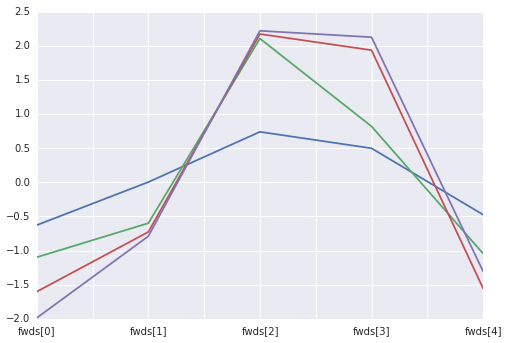

In [56]:
fwds = np.c_[-fb_data.price1.apply(np.log), fwd_rates]
yield_reg = [sm.ols('rx ~ fwds', data ={'rx' : x_rets[[i]].values, 'fwds' : fwds[:-12, :]}).fit()
             for i in range(4)]

[yield_reg[i].params[1:].plot() for i in range(4)]
[yield_reg[i].summary() for i in range(4)]

In [57]:
gamma_reg = sm.ols('rx ~ fwds', data = {'rx' : x_rets.mean(axis=1), 'fwds' : fwds[:-12]}).fit()
            
gamma_factor = np.c_[np.ones(fwds.shape[0]), fwds].dot(gamma_reg.params)
cp_reg = [sm.ols('rx ~ gf', data = {'rx' : x_rets[[i]], 'gf' : gamma_factor[:-12]}).fit() 
          for i in range(4)]

# Get b values
print('{:.4f} {:.4f} {:.4f} {:.4f}'.format(*[cp_reg[i].params.gf for i in range(4)]))

# Get R^2
print('{:.4f}'.format(gamma_reg.rsquared))
[cp_reg[i].summary() for i in range(4)]

0.4373 0.8389 1.2525 1.4712
0.2292


[<class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:                     rx   R-squared:                       0.197
 Model:                            OLS   Adj. R-squared:                  0.196
 Method:                 Least Squares   F-statistic:                     142.4
 Date:                Tue, 05 May 2015   Prob (F-statistic):           1.68e-29
 Time:                        15:12:20   Log-Likelihood:                 1579.8
 No. Observations:                 582   AIC:                            -3156.
 Df Residuals:                     580   BIC:                            -3147.
 Df Model:                           1                                         
 Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
 ---------------------------------------------------------------------

#Homework 2: Factor Analysis and Expectations Models 

Let's start with running the SVD factorisation on yield data. Note that is important to remove the mean from original data before running the SVD.

1.2774 0.3979 0.1629 0.1313 0.1196


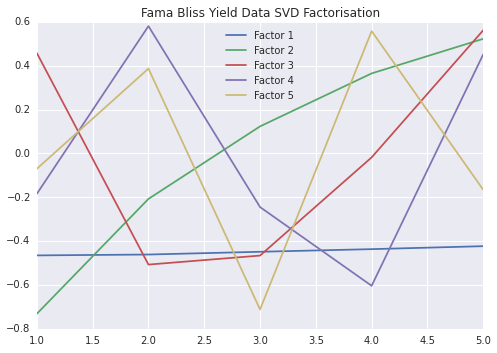

In [60]:
u, s, v = np.linalg.svd(fb_data[[i for i in fb_data.columns if i.endswith('_log_yield')
                                ]].subtract(fb_data[[i for i in fb_data.columns 
                                if i.endswith('_log_yield')]].mean(axis=0)))
factors = pd.DataFrame(-v.T, index=np.arange(1,6), columns=['Factor {:}'.format(i) 
                                                  for i in np.arange(1,6)])

print('{:.4f} {:.4f} {:.4f} {:.4f} {:.4f}'.format(*np.sqrt(s)))
factors.plot(title = 'Fama Bliss Yield Data SVD Factorisation');

Next we calculate the loadings on those factors and plot the results

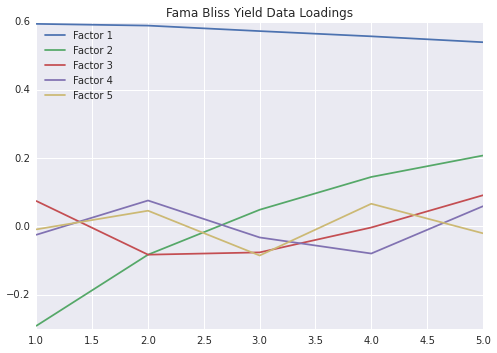

In [68]:
factors.multiply(np.sqrt(s)*[-1, 1, 1, 1, 1]).plot(title = 'Fama Bliss Yield Data Loadings');

####Question 1

In class, I showed you how the factor model formed by eigenvalue decomposition worked when applied to yields. Let's apply the same model to bond excess returns. Form the eigenvalue decomposition of the covariance matrix of the four Fama-Bliss log excess returns $rx^{(n)}_{t+1}=r^{(n)}_{t+1}−y^{(1)}_t$. Use the same sample from 196401, meaning that your first excess return will be dated 196501. Form an eigenvalue decomposition of the covariance matrix of these excess returns, and use it to construct a factor model, i.e.

$rx^{(n)}_{t+1}=\alpha+\beta_{n,1}f_{1,t+1}+\beta_{n,2}f_{2,t+1}+\beta_{n,3}f_{3,t+1}+\beta_{n,4}f_{4,t+1}$

Report the standard deviations (not variance) of the factors, in percent units, organized from largest to smallest. Enter four numbers, separated by a space, accurate to two decimal points. 

In [73]:
u,s,v = np.linalg.svd(x_rets.cov())

print('{:.4f} {:.4f} {:.4f} {:.4f}'.format(*np.sqrt(s) * 100))

8.1331 0.7880 0.2900 0.2186


####Question 2

Now calculate the loadings and weights. In the factor model

$rx^{(n)}_{t+1}=\alpha+\beta_{n,1}f_{1,t+1}+\beta_{n,2}f_{2,t+1}+\beta_{n,3}f_{3,t+1}+\beta_{n,4}f_{4,t+1}$,

"loadings" means the $\beta_{n,1}$ and "weights" means the $b_{i,n}$ that are used to construct factors from excess returns

$f_{i,t+1} = b_{i,2}rx^{(2)}_{t+1}+b_{i,3}rx^{(3)}_{t+1}+b_{i,4}rx^{(4)}_{t+1}+b_{i,5}rx^{(5)}_{t+1}$

Report the loadings on the factor with largest standard deviation, i.e. $\beta_{2,i} \, \beta_{3,i} \, \beta_{4,i} \, \beta_{5,i}$ for the $i$ with largest standard deviation. You will enter four numbers, separated by a space, accurate to two decimal places. (Eigenvectors are only defined up to sign, so enter four positive numbers not four negative numbers.)


In [74]:
print('{:.4f} {:.4f} {:.4f} {:.4f}'.format(*u[:, 0].abs())

0.2113 0.4002 0.5622 0.6922


####Question 3

Form a time series of the factors. Run a regression of each excess return on a) the first (largest standard deviation) and b) the first and second factors, including a constant,

$rx^{(n)}_{t+1}=a+\beta_{n,1} f_{1,t+1}+\varepsilon^{(n)}_{t+1}$

$rx^{(n)}_{t+1}=a+\beta_{n,1} f_{1,t+1}+\beta_{n,2}f_{2,t+1}+\varepsilon^{(n)}_{t+1}$ ,

There is an important lesson for you to learn in the betas of these regressions -- how are they different from each other? How do they relate to other quantities you have derived in doing this problem?

There is also an important lesson in the $R^2$ values. Enter the $R^2$ values from the first regression, for n=2,3,4,5, and then the $R^2$ values from the second regression in the same order, separated by a space to two decimal points. This will be eight numbers to enter.


In [75]:
factors = x_rets.dot(u)
one_factor_reg = [sm.ols('excess_ret ~ factors', data ={'excess_ret' : x_rets[[i]], 
                  'factors' : factors[[0]]}).fit() for i in range(4)]


two_factor_reg = [sm.ols('excess_ret ~ factors', data ={'excess_ret' : x_rets[[i]], 
                  'factors' : factors[[0,1]]}).fit() for i in range(4)]


print('{:.4f} {:.4f} {:.4f} {:.4f} {:.4f} {:.4f} {:.4f} {:.4f}'.format(
        *[item for sublist in [[one_factor_reg[i].rsquared for i in range(4)], 
        [two_factor_reg[i].rsquared for i in range(4)]] for item in sublist]))

print([two_factor_reg[i].summary() for i in range(4)])

0.9214 0.9798 0.9972 0.9930 0.9884 0.9976 0.9974 0.9995
[<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
Dep. Variable:             excess_ret   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                 2.469e+04
Date:                Tue, 05 May 2015   Prob (F-statistic):               0.00
Time:                        16:51:08   Log-Likelihood:                 2813.1
No. Observations:                 582   AIC:                            -5620.
Df Residuals:                     579   BIC:                            -5607.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------

####Question 4

Plot the loadings, as I plotted loadings for yield factors in class. Use your loadings and the previous questions to pick the right qualitative summary of this exercise. To think about: are these factors fundamentally the same or fundamentally different from the factors I showed in class that drive yields? 

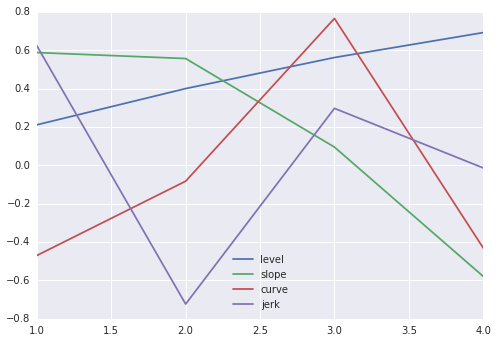

In [77]:
plt.plot(range(1,5), -u)
plt.legend(['Factor {:}'.format(i) for i in range (1,5)], loc='best');

>**Answer: Unlike yields, the first factor loadings rise almost linearly with maturity. The second factor has a curved as well as slope shape. Factors three and four are tiny without economic pattern. The two factors together account for 99% of the variance of returns. **

####Question 5

In this problem, you'll fit a two factor model. The data clearly want two factors. So, assume that the one-year rate follows

$x_t=\rho x_{t−1}+\epsilon_{x,t} \\ z_t=\phi z_{t−1}+ε_{z,t} \\ y^{(1)}_t=a+x_t+z_t$

Use the expectations hypothesis to derive an expression for forward rates $f^{(n)}_t$ in terms of $x_t$, $z_t$ and the parameters $a,\phi,\rho$. Hint: $E_t(x_{t+n})=\rho^nx_t$

Your answer should look like $f^{(n)}_t=a+(⋅)x_t+(⋅)z_t$. You have to find the expressions in (⋅) which depend on the parameters of the problem. Thus, you're staring at a two-factor model for forward rates, in which $x_t$ and $z_t$ are the factors. This problem does not require any big algebra.

To check your formula, use $a=0.06, \; \rho=0.95, \; \phi=0.60$ and enter the loadings on the first two forward rates, i.e. the (⋅) in

$f^{(2)}_t=a+(⋅)x_t+(⋅)z_t \\ f^{(3)}_t=a+(⋅)x_t+(⋅)z_t$

Enter four numbers, with spaces in between, accurate to two decimal places.

In [117]:
def loadings(n, rho=.95, phi=0.6):
    return rho**(n - 1) , phi**(n - 1)

print('{:.4f} {:.4f} {:.4f} {:.4f}'.format(*[item for sublist in [loadings(2), loadings(3)]
                                             for item in sublist]))

0.9500 0.6000 0.9025 0.3600


####Question 6
Find the corresponding two-factor model for yields. The easiest approach is to use*

$y_{t}^{(n)}=\frac{1}{n}\left( y_{t}^{(1)}+f_{t}^{(2)}+...+f_{t}^{(n)}\right) .$

You can make the answers prettier with

$1+c+c^{2}+..+c^{n-1}=\frac{1-c^{n}}{1-c}$

Your answer should look like

$y_{t}^{(n)}=a+(\cdot )x_{t}+(\cdot )z_{t}$

Again, enter the first two non-trivial terms (you know the answer for $y^{(1)}_t$)

$y_{t}^{(2)}=a+(\cdot )x_{t}+(\cdot )z_{t} \\ y_{t}^{(3)}=a+(\cdot )x_{t}+(\cdot )z_{t}$

You will enter four numbers, separated by a space, accurate to two decimal places.


*Where did this come from? It's an identity. More generally, you can always discount the future using today's forward rates:

$p_{t}^{(n)} =p^{(1)}-(p_{t}^{(1)}-p_{t}^{(2)})-(p_{t}^{(3)}-p_{t}^{(2)})-...-(p_{t}^{(n-2)}-p_{t}^{(n-1)})-(p_{t}^{(n-1)}-p_{t}^{(n)}) \\ p_{t}^{(n)} =-y_{t}^{(1)}-f_{t}^{(2)}-...-f_{t}^{(n-1)}-f_{t}^{(n)} \\ y_{t}^{(n)} =-np_{t}^{(n)}=\frac{1}{n}\left( y_{t}^{(1)}+f_{t}^{(2)}+...+f_{t}^{(n)}\right)$


In [121]:
def yields(n, rho = 0.95, phi = 0.6):
    f = lambda x: (1 - x**n) / (1 - x)
    return f(rho) / n, f(phi) / n

print('{:.4f} {:.4f} {:.4f} {:.4f}'.format(*[item for sublist in [yields(2), yields(3)]
                                             for item in sublist]))

0.9750 0.8000 0.9508 0.6533


#Homework 3: Discrete-Time Vasicek Meets Fama and Bliss 

####Question 1
Let's modify the basic Vasicek term structure model, and see if we can account for Fama-Bliss regressions. The basic model has a constant market price of risk. We need to have a time-varying price of risk. The obvious way to do that is just to make the price of risk depend on the single factor, which is the only thing that's time varying in this model. (More realistically, we add more factors, but not in a homework!)

So, let's pursue the obvious extension, in which rather than just $\lambda$ we have a time-varying $\lambda_t=\lambda_1x_t$. The model is now

$x_{t+1}=\phi x_t+\epsilon_{t+1} \\ m_{t+1}=\log M_{t+1} =-x_{t}-\frac{1}{2}\left( \lambda _{1}x_{t}\right) ^{2}\sigma _{\varepsilon }^{2}-\left( \lambda _{1}x_{t}\right) \varepsilon _{t+1} \\ p^{(n)}_t=\log E_t \left( e^{m_{t+1} + p^{(n-1)}_{t+1}} \right)$

(In real life you'd allow a constant too, $\lambda_t=\lambda_0+\lambda_1x_t$, but I'm simplifying the algebra a bit. I also set to zero the constant $\delta$, which isn't realistic since the mean interest rate is not zero, but that just shifts everything up. )

Find expressions for $p^{(1)}_t, p^{(2)}_t$, hence $y^{(1)}_t,f^{(2)}_t$, in this model. They are still linear functions $a_n+b_n×x_t$!

Hint: You have to use $Ee^{x}=e^{E(x)+\frac{1}{2}\sigma ^{2}(x)}$, exactly as we did in lecture. Follow the steps as in lecture! It's not as hard as it looks.

To check your answer, calculate $a_2, b_2$ in

$p^{(2)}_t=a_2+b_2×xt$

Use $\sigma^2_\epsilon=0.1, \phi=0.9, \lambda_1=0.5$. (These values are not realistic, but they are relatively easy to calculate and let us check if you got the right answer.) Enter these two numbers, separated by a space, to two decimal places


In [160]:
def vasicek(n, sigma=0.1, phi=0.9, lam=0.5):
    return 0.5 * sigma, - (1 + phi) + sigma * lam

print('{:.4f} {:.4f}'.format(*vasicek(2)))

0.0500 -1.8500


####Question 2

Continuing, calculate $c_2, d_2$ in

$f^{(2)}_t=c_2+d_2×x_t$

using the same parameters. You enter two numbers, separated by a space, to two decimal places.


In [161]:
print('{:.4f} {:.4f}'.format(-vasicek(2)[0], - (1 + vasicek(2)[1])))

-0.0500 0.8500


####Question 3

Find an expression for $rx^{(2)}_{t+1}=p^{(1)}_{t+1}−p^{(2)}_t+p^{(1)}_t$. This is a function $rx^{(2)}_{t+1}=a+bx_t+c\epsilon_{t+1}$. Hence, find $E_trx^{(2)}_{t+1}=a+bx_t$. Using the same parameters, enter your values for a and b, which will be two numbers, to two decimal places, separated by a space.


In [166]:
phi = 0.9

print('{:.4f} {:.4f}'.format(-vasicek(2)[0],  -(1 + phi + vasicek(2)[1])))

-0.0500 -0.0500


####Question 4

Find the predicted value of the Fama-Bliss slope coefficients, i.e. find $\beta$ in

$E_trx^{(2)}_{t+1}=\alpha+\beta(f^{(2)}_t−y^{(1)}_t).$

All you're doing here is substituting out the previous results. You had

$E_{t}(rx_{t+1}^{(2)})=a+bx_{t} \\ (f_{t}^{(2)}-y_{t}^{(1)})=c+dx_{t}$

so you're just getting rid of xt on the right hand side in favor of $f^{(2)}_t−y^{(1)}_t$. Now,

$E_{t}rx_{t+1}^{(2)}=\left( \text{mess}\right) +\frac{b}{d}(f_{t}^{(2)}-y_{t}^{(1)})$

So, forget the mess in the constant, we're only interested in the slope coefficient, b/d. Find an algebraic expression for b/d and enter its value using the same parameters, to two decimal places. Since that won't be very close to the actual value, also calculate the coefficient for $\phi=1$, which is as close as I can get this model to reflect the Fama Bliss regression coefficient. Thus, you are entering two numbers, to two decimal places, separated by a space.


In [173]:
def fama_bliss_slope(n=2, phi=0.9, sig2=0.1, lam=0.5):
    d = - (1 + vasicek(n)[1])
    b = - (1 + phi + vasicek(n)[1])
    return b / (d - 1)

print('{:.4f} {:.4f}'.format(fama_bliss_slope(), fama_bliss_slope(phi=1)))

0.3333 1.0000


#Homework 4: Continuous-Time Term Structure

####Question 1
We often think of the yield curve as having at least one factor that is a level factor with a parallel shift. In this problem, we will see this is impossible -- all yield curve factors must eventually die out, and the asymptotic long rate must be constant -- if enough securities are traded. The buzzword is "convexity," but we'll see the problem directly.

Suppose that yields of all maturities are the same and follow parallel shifts,

$dy=\mu dt+\sigma dz_{t}$

$\mu$ and $\sigma$ can vary over time, so they are the instantaneous means $\mu_t$ and $\sigma_t$. The price of an $n$-year bond is, of course,

$P(n,t)=e^{−ny_t}$

The return of an n year bond is

$ddR(n,t)=\frac{dP(n,t)}{P}-\frac{1}{P}\frac{\partial P(n,t)}{\partial n}dt$

You need to be quite careful here, which is a lot of the point of this problem. First, as explained in lecture, we need the second term because $P(n,t)$ is the price of a maturity, not the price of a bond. $n$ is a constant, not a function of time. (If $P$ denoted the price of a given bond, then n would decline as the bond ages.) You should review the derivation of this return to make sure you know where it comes from and won't omit it by mistake. Second, $dP(n,t)$ means $P(n,t+\Delta)−P(n,t)$. You can't take $\partial{P}/\partial{t}$! You can take $\partial{P(n,t)}/\partial{n}$. $dP$ does not mean $\frac{\partial P}{\partial t}dt+\frac{\partial P}{\partial n}dn$!

(If this is confusing to you, don't worry: Aaron screwed it up, too! It boils down to an issue of notation, nothing more. For the die-hard term-structure nerds out there, he's started a forum thread outlining a different notation than the one used here. Best not to look at it until after you've finished this homework.)

OK, now use Ito's lemma to find $dR(n,t)−r^f_tdt$ under the parallel shifts assumption. (Hint: $r^f_t=y_t$.)

>**Answer: $dR(n,t)=-ndy_{t}+\frac{1}{2}n^{2}dy_{t}^{2}+y_{t}dt=-n\left( \mu dt+\sigma dz_{t}\right) +\frac{1}{2}n^{2}\sigma ^{2}dt+y_{t}dt \\
r^f_t=y_t \\
dR(n,t)-r_{t}^{f}dt=\left( \frac{1}{2}n^{2}\sigma ^{2}-n\mu \right) dt-n\sigma dz_{t}$**

####Question 2

Now find the annualized Sharpe ratio of the $n$ - year bond. Reminder, if $dR_t=rf_tdt+\mu dt+\sigma dz_t$, then the annualized Sharpe ratio is simply $\mu/\sigma$. Again enter your answer as an algebraic expression using "mu", "sigma", and "n". There are no $dt$ or $dz$ terms in this expression. Enter the actual Sharpe ratio, not its absolute value. Positive $\mu$ means yields drift up means prices drift down, so one of your terms will be negative. Include that negative term as a negative.

>**Answer: $\frac{\frac{1}{2}n^{2}\sigma ^{2}-n\mu }{n\sigma }=-\frac{\mu }{\sigma }+\frac{1}{2}n\sigma$**


####Question 3

What is the limit of the Sharpe ratio of an n-year bond, when the yield curve has parallel shifts, as $n \rightarrow \infty$?

>**Answer: $\infty $**

####Question 4
We reviewed the discrete-time Vasicek model by doing the same model with a time-varying market price of risk. Let's do the same thing for the continuous time model. Modify the model to

$dr_{t} =-\phi r_{t}dt+\sigma _{r}dz_{t}$

$\frac{d \Lambda _{t}}{\Lambda } =-r_{t}dt-\sigma _{\Lambda} {r}_{t}dz_{t}$

As in discrete time, I simplified by leaving out a positive mean of the short rate, $\bar{r}$, and by leaving out a constant in the market price of risk, which could be $\lambda_0+\lambda_1r_t$. The only addition is, where we had \sigma_Lambda$, now we have $\sigma\Lambda r_t$.

Retrace the steps of the single-factor model we derived in lecture with this modification. You do not have to compute the $A(n)$. Do get to the new differential equation for the $B(n)$ and solve it. Use the notation $\phi^* \equiv \phi +\sigma _{r}\sigma _{\Lambda }$ to simplify your answer. Report your formula for B(n) as a "math expression". 

Hint: In the end you can interpret $\Phi^*$ as the risk-neutral dynamics. This model ends up with a cross section that is priced as if $\Phi$ is replaced with this distorted probability $\Phi^*$, just as the regular model had a distorted mean. It's really pretty when you're done.

####**Answer**

$dr_{t} =-\phi r_{t}dt+\sigma _{r}dz_{t}$

$\frac{d \Lambda _{t}}{\Lambda } =-r_{t}dt-\sigma _{\Lambda} \mathbf{r}_tdz_t$

I made $r$ bold where it changes -- the rest of the formula is unchanged. We now have a time-varying market price of risk. As in discrete time, I simplified by leaving out a positive mean of the short rate, $\bar{r}$, and by leaving out a constant in the market price of risk, which could be $\lambda_0+\lambda_1r_t$.

Plugging in to the pricing equation, we now just have $\sigma\Lambda r$ where we had $\sigma\Lambda$, or

$\frac{\partial P}{\partial r}\mu _{r}+\frac{1}{2}\sigma _{r}^{2}\frac{\partial ^{2}P}{\partial r^{2}}-\frac{\partial P}{\partial n}-rP=\sigma _{r}\sigma _{\Lambda } {\bf r}\frac{\partial P}{\partial r}$

$\frac{\partial P(n,r)}{\partial n}=\left( \mu _{r}-\sigma _{r}\sigma _{\Lambda }\bf{r}\right) \frac{\partial P(n,r)}{\partial r}+\frac{1}{2}\frac{\partial ^{2}P(n,r)}{\partial r^{2}}\sigma _{r}^{2}-rP(n,r)$

and plug in -- nothing has changed except we got rid of $\bar{r}$ and we added the boldface r.

$\frac{\partial P}{\partial n}=\left( -\phi r-\sigma _{r}\sigma _{\Lambda }\bf{r}\right) \frac{\partial P}{\partial r}+\frac{1}{2}\frac{\partial ^{2}P}{\partial r^{2}}\sigma _{r}^{2}-rP$

Again, we guess

$P(n,r)=e^{A(n)−B(n)r}$

$\frac{\partial P}{\partial r} =-B(n)P$

$\frac{\partial ^{2}P}{\partial r^{2}} =B(n)^{2}P$

$\frac{\partial P}{\partial n} =\left[ A^{\prime }(n)-B^{\prime }(n)r\right] P$

Our case is therefore

$A^{\prime }(n)-B^{\prime }(n)r=-\left[ -\phi r-\sigma _{r}\sigma _{\Lambda }\bf{r}\right] B(n)+\frac{1}{2}\sigma _{r}^{2}B(n)^{2}-r$

True for every r, so constant and terms in r must equal. No more boldface. This just puts the $\sigma\Lambda$ in with the $r$ term and the $B$ rather than the constant term and the $A$

$A^{\prime }(n)=\frac{1}{2}\sigma _{r}^{2}B(n)^{2}$

$B^{\prime }(n)=1-\left( \phi +\sigma _{r}\sigma _{\Lambda }\right) B(n)=1-\phi ^{\ast }B(n)$

$B(n)=\frac{1}{\phi ^{\ast }}(1-e^{-\phi ^{\ast }n})$

In the last lines, I defined $\Phi^*$. This is the risk neutral transition matrix. The time-varying market price of risk model is equivalent to a risk-neutral distortion on $Phi$, where the constant market price of risk was equivalent to a distortion on the mean $\bar{r}$.